# Step1資料準備

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(x_train_10,y_train_10),(x_test_10,y_test_10)=cifar10.load_data()
y_train_10 = to_categorical(y_train_10)
y_test_10 = to_categorical(y_test_10)



In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.layers import Lambda, Dropout,Input, Activation, Dense, GlobalAveragePooling2D, Conv2D,Add, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback,LearningRateScheduler, TensorBoard, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import Model_mobilenet
from Model_mobilenet import MobileNet,MobileNet_drop
from image_noise import Rand_Augment

In [4]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [5]:
teacher_model = teacher_model = load_model('teacher_model_624.h5')

In [6]:
img_path = r"E:\NCHU_PHD\10902sml\data_set\add"
img_list = os.listdir(img_path)

x_train_imgnet = []

for i in img_list:
    abs_path = os.path.join(img_path, i)
    temp = load_img(abs_path)
    temp = img_to_array(temp)
    x_train_imgnet.append(temp)

x_train_imgnet = np.array(x_train_imgnet)

batch_size = 40
step = int(x_train_imgnet.shape[0] / batch_size)
print(step)

y_train_imgnet_dummy = []

for i in range(step):
    x_temp = x_train_imgnet[batch_size*i:batch_size*(i+1)]
    x_temp = x_temp / 255.
    temp = teacher_model.predict(x_temp)
    y_train_imgnet_dummy.extend(temp)

y_train_imgnet_dummy = np.array(y_train_imgnet_dummy)

1750


In [8]:
y_train_imgnet_dummy_th =  y_train_imgnet_dummy
x_train_imgnet_th = x_train_imgnet


y_student_all_dummy_label = np.argmax(y_train_imgnet_dummy_th, axis=1)

u, counts = np.unique(y_student_all_dummy_label, return_counts=True)
print(u, counts)

student_label_max =  max(counts)

y_student_per_label = []
y_student_per_img_path = []

for i in range(10):
    temp_l = y_train_imgnet_dummy_th[y_student_all_dummy_label == i]
    print(i, ":", temp_l.shape)
    y_student_per_label.append(temp_l)
    temp_i = x_train_imgnet_th[y_student_all_dummy_label == i]
    print(i, ":", temp_i.shape)
    y_student_per_img_path.append(temp_i)

[0 1 2 3 4 5 6 7 8 9] [8857 7104 6319 7199 8944 4746 8508 6691 4780 6852]
0 : (8857, 10)
0 : (8857, 32, 32, 3)
1 : (7104, 10)
1 : (7104, 32, 32, 3)
2 : (6319, 10)
2 : (6319, 32, 32, 3)
3 : (7199, 10)
3 : (7199, 32, 32, 3)
4 : (8944, 10)
4 : (8944, 32, 32, 3)
5 : (4746, 10)
5 : (4746, 32, 32, 3)
6 : (8508, 10)
6 : (8508, 32, 32, 3)
7 : (6691, 10)
7 : (6691, 32, 32, 3)
8 : (4780, 10)
8 : (4780, 32, 32, 3)
9 : (6852, 10)
9 : (6852, 32, 32, 3)


In [9]:
y_student_per_label_add = []
y_student_per_img_add = []

for i in range(10):
    num = y_student_per_label[i].shape[0]
    temp_l = y_student_per_label[i]
    temp_i = y_student_per_img_path[i]
    add_num = student_label_max - num
    

    p = (-temp_l[:,0]).argsort()
    temp_l_new = temp_l[p]
    temp_i_new= temp_i[p]
    y_student_per_label_add.append(temp_l_new[:4500])
    y_student_per_img_add.append(temp_i_new[:4500])

print([len(i) for i in y_student_per_label_add])

student_train_img = np.concatenate(y_student_per_img_add, axis=0)
student_train_label = np.concatenate(y_student_per_label_add, axis=0)

x_train_student = student_train_img
y_train_student = student_train_label

[4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500, 4500]


# Step2 模型建立


In [10]:
x_train_student.shape

(45000, 32, 32, 3)

### Student_model 訓練

In [11]:
img_input=Input(shape=(32,32,3))
output = MobileNet(img_input)
student_model_billion = Model(img_input,output)
student_model_billion.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 24)        672       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 24)        96        
_________________________________________________________________
activation (Activation)      (None, 16, 16, 24)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 24)        240       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 24)        0     

In [12]:
import os

In [15]:
log_dir = 'logs/softlabel/student1_2/'
batch_size = 64

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',\
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

student_model_billion.compile(loss = "categorical_crossentropy",optimizer = "adam", metrics = ["accuracy"])

batch_size = 64
steps_per_epoch = x_train_student.shape[0] // batch_size
validation_steps = x_test_10.shape[0] // batch_size
train_gen = ImageDataGenerator(rescale = 1./255.).flow(x_train_student,y_train_student, batch_size)
val_gen = ImageDataGenerator(rescale = 1./255.).flow(x_test_10,y_test_10, batch_size)


history = student_model_billion.fit_generator(train_gen,
                                      initial_epoch=0,
                                      epochs=50,
                                      steps_per_epoch = steps_per_epoch,
                          validation_data = val_gen, validation_steps = validation_steps,
                          callbacks=[checkpoint, reduce_lr, early_stopping])





Epoch 1/50
703/703 [==============================] - 77s 109ms/step - loss: 2.0828 - accuracy: 0.2328 - val_loss: 2.0107 - val_accuracy: 0.2549
Epoch 2/50
703/703 [==============================] - 77s 110ms/step - loss: 1.8145 - accuracy: 0.3470 - val_loss: 1.6914 - val_accuracy: 0.3825
Epoch 3/50
703/703 [==============================] - 77s 109ms/step - loss: 1.7220 - accuracy: 0.3900 - val_loss: 2.5591 - val_accuracy: 0.3218
Epoch 4/50
703/703 [==============================] - 78s 111ms/step - loss: 1.6625 - accuracy: 0.4159 - val_loss: 1.4721 - val_accuracy: 0.4581
Epoch 5/50
703/703 [==============================] - 77s 110ms/step - loss: 1.5821 - accuracy: 0.4569 - val_loss: 1.4361 - val_accuracy: 0.4666
Epoch 6/50
703/703 [==============================] - 78s 110ms/step - loss: 1.5200 - accuracy: 0.4828 - val_loss: 1.4352 - val_accuracy: 0.4671
Epoch 7/50
703/703 [==============================] - 78s 111ms/step - loss: 1.4834 - accuracy: 0.5044 - val_loss: 1.3419 - val_ac

In [16]:
student_model_billion.save('student_model_billion_624_part.h5')


In [17]:
batch_size = 64
steps_per_epoch = y_train_10.shape[0] // batch_size
validation_steps = x_test_10.shape[0] // batch_size

log_dir = 'logs/softlabel/student_billion/'

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [18]:
train_gen = ImageDataGenerator(rescale = 1./255.).flow(x_train_10,y_train_10, batch_size)
val_gen = ImageDataGenerator(rescale = 1./255.).flow(x_test_10,y_test_10, batch_size)

history = student_model_billion.fit_generator(train_gen,
                                      initial_epoch=27,
                                      epochs=100,
                                      steps_per_epoch = steps_per_epoch,
                          validation_data = val_gen, validation_steps = validation_steps,
                          callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 28/100
781/781 [==============================] - 91s 116ms/step - loss: 0.9798 - accuracy: 0.6555 - val_loss: 1.0023 - val_accuracy: 0.6457
Epoch 29/100
781/781 [==============================] - 85s 109ms/step - loss: 0.9792 - accuracy: 0.6578 - val_loss: 1.0028 - val_accuracy: 0.6461
Epoch 30/100
781/781 [==============================] - 85s 109ms/step - loss: 0.9774 - accuracy: 0.6557 - val_loss: 1.0012 - val_accuracy: 0.6461
Epoch 31/100
781/781 [==============================] - 87s 111ms/step - loss: 0.9783 - accuracy: 0.6562 - val_loss: 1.0012 - val_accuracy: 0.6461
Epoch 32/100
781/781 [==============================] - 86s 110ms/step - loss: 0.9804 - accuracy: 0.6555 - val_loss: 1.0010 - val_accuracy: 0.6460
Epoch 33/100
781/781 [==============================] - 85s 108ms/step - loss: 0.9765 - accuracy: 0.6553 - val_loss: 1.0026 - val_accuracy: 0.6463
Epoch 34/100
781/781 [==============================] - 85s 109ms/step - loss: 0.9786 - accuracy: 0.6548 - val_loss: 0

In [19]:
student_model_billion.save('student_model_billion_624.h5')
history.history.keys()
student_billion = pd.DataFrame(history.history, index=range(1,len(history.history['loss'])+1))
student_billion.to_csv('E:/NCHU_PHD/10902sml/report2/final_624/student_billion.CSV')



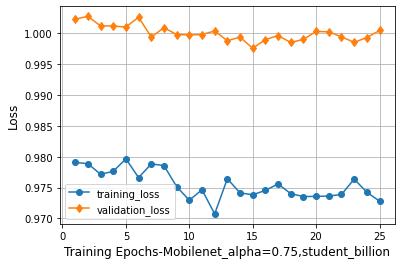

In [20]:
from matplotlib import pyplot as plt
plt.plot(student_billion['loss'], marker='o', label='training_loss')
plt.plot(student_billion['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75,student_billion', fontsize=12)
plt.grid()
plt.legend()

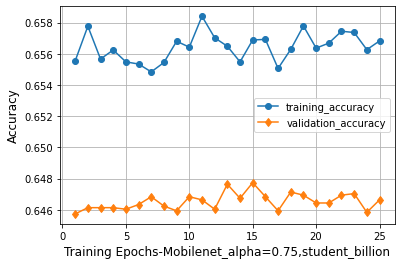

In [21]:
plt.plot(student_billion['accuracy'], marker='o', label='training_accuracy')
plt.plot(student_billion['val_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs-Mobilenet_alpha=0.75,student_billion', fontsize=12)
plt.grid()
plt.legend()

### Test

In [22]:
###test
img_path = "E:/NCHU_PHD/10902sml/data_set/add_test"
img_list = os.listdir(img_path)

x_test = []
y_test = []

for i in img_list:
    img_list_= img_path +"/"+i
    for j in os.listdir(img_list_):
        abs_path = img_path +"/"+i +"/"+j
        temp = load_img(abs_path)
        temp = img_to_array(temp)
        x_test.append(temp)
        y_test.append(i)
    
x_test = np.array(x_test)
y_test = np.array(y_test).reshape((500, 1))
y_test = to_categorical(y_test)

def my_eval(model,x,t):
    ev = model.evaluate(x,t, batch_size=10)
    print("loss:"+str(round(ev[0],4)))
    print("acc: "+str(ev[1]))

my_eval(student_model_billion,x_test/255,y_test)

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

loss:1.6358
acc: 0.488
